In [1]:
import pandas as pd
from scipy import stats
import scipy.stats as sc
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import heapq
import common_function as CF

In [2]:
#path for summary of radius of gyration
reference_radius_path='../data/json/reference_radius.json'
isoform_radius_path='../data/json/isoform_radius.json'
difference_radius_path='../data/json/difference_radius.json'
#path for as event
as_event_path='../data/json/as_event.json'
#path for quality
reference_high_confident_path='../data/csv/reference_high_confident.csv'
isoform_high_confident_path='../data/csv/isoform_high_confident.csv'

<span style="font-size: 20px;">Plot radius of gyration distribution: </span>

In [3]:
radius_reference = CF.load_file_json(reference_radius_path)
radius_isoform = CF.load_file_json(isoform_radius_path)
radius_difference = CF.load_file_json(difference_radius_path)
as_event = CF.load_file_json(as_event_path)
reference_high_confident = pd.read_csv(reference_high_confident_path)
isoform_high_confident = pd.read_csv(isoform_high_confident_path)

In [4]:
#select only high and confident structures
radius_isoform,radius_reference,radius_difference = CF.combine_quality_metric(reference_high_confident,isoform_high_confident,radius_reference,radius_isoform,radius_difference)

In [5]:
#plot distribtion
def plot_distribtion_box(isoform_radius,reference_radius,outliers = True):
    plot_df=pd.DataFrame(columns=['Class','Radius of gyration'])
    index=0
    radius_list=list(isoform_radius.values())+list(reference_radius.values())
    plot_df['Class']=['Isoform']*len(isoform_radius)+['Reference']*len(reference_radius)
    plot_df['Radius of gyration']=radius_list
    
    plt.figure(figsize=(2,4))
    box_colors = ['#F3BF70','#25D9F5']

    if outliers==False:
        sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,palette="Set3",showfliers = False,notch=True)
    else:  
        sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors,order=['Reference','Isoform'])
    plt.xlabel('')

    plt.ylabel("Radius of gyration(Å)",fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(range(0, 160, 30),fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    return plot_df

,Class,Radius of gyration
0,Isoform,26.232095
1,Isoform,33.301574
2,Isoform,18.691617
3,Isoform,31.025828
4,Isoform,23.020816
...,...,...
11063,Reference,14.386634
11064,Reference,37.517719
11065,Reference,63.398830
11066,Reference,19.471702


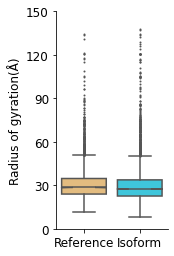

In [6]:
plot_distribtion_box(radius_isoform,radius_reference)

In [7]:
#select the isoforms with alternative splicing types
radius_isoform_type,radius_difference_type=CF.combine_quality_type(radius_isoform,radius_difference,as_event)

In [8]:
def plot_difference_outlier_box(difference_radius_type):
    difference_radius_type_new={}
    for isoform in difference_radius_type.keys():
        difference_radius_type_new[isoform]=difference_radius_type[isoform][0]
    plot_df = pd.DataFrame()
    plot_df['Isoform']=list(difference_radius_type_new.keys())
    plot_df['Radius of gyration difference']=list(difference_radius_type_new.values())
    plot_df['Class']='Isoform'
    fig = plt.figure(figsize=(2,4))
    box_colors = ['#25D9F5']
    sns.boxplot(data=plot_df, x='Class', y='Radius of gyration difference',flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors)
    plt.xlabel('')
    plt.ylabel('Radius of gyration difference(Å)',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(range(-60, 70, 30),fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.show()
    return plot_df

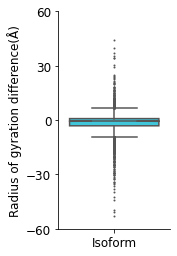

In [9]:
plot_df=plot_difference_outlier_box(radius_difference_type)

<span style="font-size: 20px;">Select outlier examples and plot the alternative splicing types in radius of gyration outliers: </span>

In [10]:
def calculate_outliters_radius(radius_difference_dic):
    radius_difference_list=[]
    for radius in radius_difference_dic.values():
        radius_difference_list.append(radius[0])
    Q1=np.percentile(radius_difference_list,25)
    Q3=np.percentile(radius_difference_list,75)
    IQR=1.5*(Q3-Q1)
    upper_bound=Q3+IQR
    lower_bound=Q1-IQR
    lower_list=[]
    upper_list=[]
    for k,v in radius_difference_dic.items():
        if v[0]>=upper_bound:
            upper_list.append(k)
        elif v[0]<=lower_bound:
            lower_list.append(k)
        else:
            continue
    return upper_list,lower_list,upper_bound,lower_bound

In [11]:
upper_list,lower_list,upper_bound,lower_bound=calculate_outliters_radius(radius_difference_type)

In [12]:
def replace_as_abb_dic(plot_dic):
    new_plot_dic={}
    as_name_dic={'exon_skipping':'ES',
                 'alternative_donor_site':'ADS',
                 'alternative_acceptor_site':'AAS',
                 'mutually_exclusive_exon':'MXE',
                 'intron_retention':'IR',
                 'alternative_first_exon':'AFE',
                 'alternative_last_exon':'ALE',
                 'mutually_exclusive_exon-alternative_first_exon':'MXE-AFE',
                 'mutually_exclusive_exon-alternative_last_exon':'MXE-ALE'}
    for key in plot_dic.keys():
        new_plot_dic[as_name_dic[key]]=plot_dic[key]
    return new_plot_dic

In [13]:
def get_feature(charge_list,charge_dic):
    count_feature={}
    for isoform in charge_list:
        for feature in charge_dic[isoform][1]:
            if feature in count_feature.keys():
                count_feature[feature]+=1
            else:
                count_feature[feature]=1
    return count_feature

In [14]:
feature_upper=get_feature(upper_list,radius_difference_type)
feature_lower=get_feature(lower_list,radius_difference_type)

In [15]:
def plot_otlier_event_frequent_pair(positive_outlier,negative_outlier,threshold=5):
    selected_positive_outlier_pair = heapq.nlargest(threshold, positive_outlier.items(), key=lambda item: item[1])
    selected_negative_outlier_pair = heapq.nlargest(threshold, negative_outlier.items(), key=lambda item: item[1])
    sorted_positive_outlier = dict(selected_positive_outlier_pair)
    sorted_negative_outlier = dict(selected_negative_outlier_pair)
    sorted_positive_outlier = replace_as_abb_dic(sorted_positive_outlier)
    sorted_negative_outlier = replace_as_abb_dic(sorted_negative_outlier)
    
    as_list=list(sorted_positive_outlier.keys())
    positive_outlier_list=list(sorted_positive_outlier.values())
    negative_outlier_list=[sorted_negative_outlier[i] for i in as_list]

    bar_width = 0.4
    bar1_positions = range(len(as_list))
    bar2_positions = [x + bar_width for x in bar1_positions]
 
    plt.bar(bar1_positions, positive_outlier_list, width=bar_width, label='positive',color='#000099')
    plt.bar(bar2_positions, negative_outlier_list, width=bar_width, label='negative',color='#FF0000')
    
    plt.xticks([x + bar_width/2 for x in bar1_positions], as_list,fontsize=14)
    plt.legend(fontsize=12)
    plt.xlabel('AS event type',fontsize=14)
    plt.ylabel('AS event number',fontsize=14)
    plt.yticks(range(0, 310, 60),fontsize=14)
    plt.show()
    return True

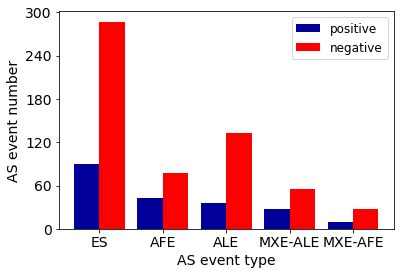

True

In [16]:
plot_otlier_event_frequent_pair(feature_upper,feature_lower)